Pre-COVID19

In [ ]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('/home/yzwang/MF/github')))
sys.path.append(os.path.abspath(os.path.join('/home/yzwang/MF/github/Method')))
import numpy as np
from datetime import datetime
from Baseline import set_seed
from utils import (root_mean_squared_error, mean_absolute_error, create_lagged_data,
                   three_frequency_convert_to_lowest,plot_forecasts_multi)
np.printoptions(precision=4, suppress=True)
np.set_printoptions(precision=4, suppress=True)
set_seed(42)

#data parameters
d1 = 20
d2 = 3
P1 = 13
P2 = 56
QP3 = 9
Q = 5

T = 188
T_val = 20
T_test = 20
T_train = T - T_val - T_test

T_M = T * d2
T_H = T * d1 * d2
print('T',T,'T_H:', T_H, 'T_M:', T_M)
print('T_train:', T_train, 'T_val:', T_val, 'T_test:', T_test)

Y = np.load(f'../data_clean/Y_std.npy')[:,:T]
X_M = np.load(f'../data_clean/X_M_std.npy')[:,:T*d2]
X_H = np.load(f'../data_clean/X_H_std.npy')[:,:T*d1*d2]

print('Y shape:', Y.shape)
print('X_M shape:', X_M.shape)
print('X_H shape:', X_H.shape)
print('Y max:', np.max(Y), 'Y min:', np.min(Y), 'Y mean:', np.mean(Y), 'Y std:', np.std(Y))
print('X_M max:', np.max(X_M), 'X_M min:', np.min(X_M), 'X_M mean:', np.mean(X_M), 'X_M std:', np.std(X_M))
print('X_H max:', np.max(X_H), 'X_H min:', np.min(X_H), 'X_H mean:', np.mean(X_H), 'X_H std:', np.std(X_H))

Y_total = three_frequency_convert_to_lowest(Y, X_M, X_H, d1, d2)
print('Y_total shape:', Y_total.shape)

T 188 T_H: 11280 T_M: 564
T_train: 148 T_val: 20 T_test: 20
Y shape: (9, 188)
X_M shape: (56, 564)
X_H shape: (13, 11280)
Y max: 9.083060657379114 Y min: -4.5941919722762705 Y mean: 0.003900497296983884 Y std: 0.87206867900193
X_M max: 16.940348022306395 X_M min: -17.12817591268496 X_M mean: 0.00039118324278265517 X_M std: 0.8661968246394718
X_H max: 23.195031218753527 X_H min: -25.564933640672024 X_H mean: 7.850425864522082e-05 X_H std: 0.9699726059297447
Y_total shape: (957, 188)



----- Evaluating Direct Multi-Step Forecasting for Horizon = t+1 -----

=== Horizon 1 (Direct Forecast t+1) ===
True matrix:
 [[-0.1516  0.3905 -0.1324 -0.6072 -1.002 ]
 [ 0.2088  0.0433  0.642   0.2094 -0.4758]
 [-0.0477 -0.0281 -0.1132  0.6587  2.1758]
 [-0.2482 -0.0138 -0.1579  0.1172 -0.9528]
 [-0.446  -0.283  -0.3616 -0.0008 -0.8465]
 [-0.0842  0.0321 -0.3194  0.5813 -0.2115]
 [-0.3207 -0.2021 -0.3185 -0.6105  2.4701]
 [ 0.0345 -0.0215 -0.1056  0.0058 -1.417 ]
 [-0.1072 -0.1843  0.4641 -0.3055  0.6385]
 [-0.1689  0.0447 -0.2786 -0.8523  0.1926]
 [-0.1021 -0.2022  0.1775 -0.1767 -0.7769]
 [ 0.1067 -0.0376  0.2002 -0.3682  0.7686]
 [ 0.415   0.3369  0.2529  0.5607  0.1578]
 [ 0.1294  0.0043  0.1643 -0.2638  0.0324]
 [-0.1287 -0.1664 -0.2158  0.3437  0.4138]
 [-0.0438 -0.2339  0.5355  0.4317 -0.9276]
 [-0.4853 -0.3686 -0.1952 -0.354  -0.0723]
 [-0.0432 -0.5085 -0.0067  1.1385 -0.3261]
 [ 0.1492  0.1208  0.0163  1.1072  1.0158]
 [ 0.454   0.3751 -0.016   0.8511 -1.0362]]
Forecast mat

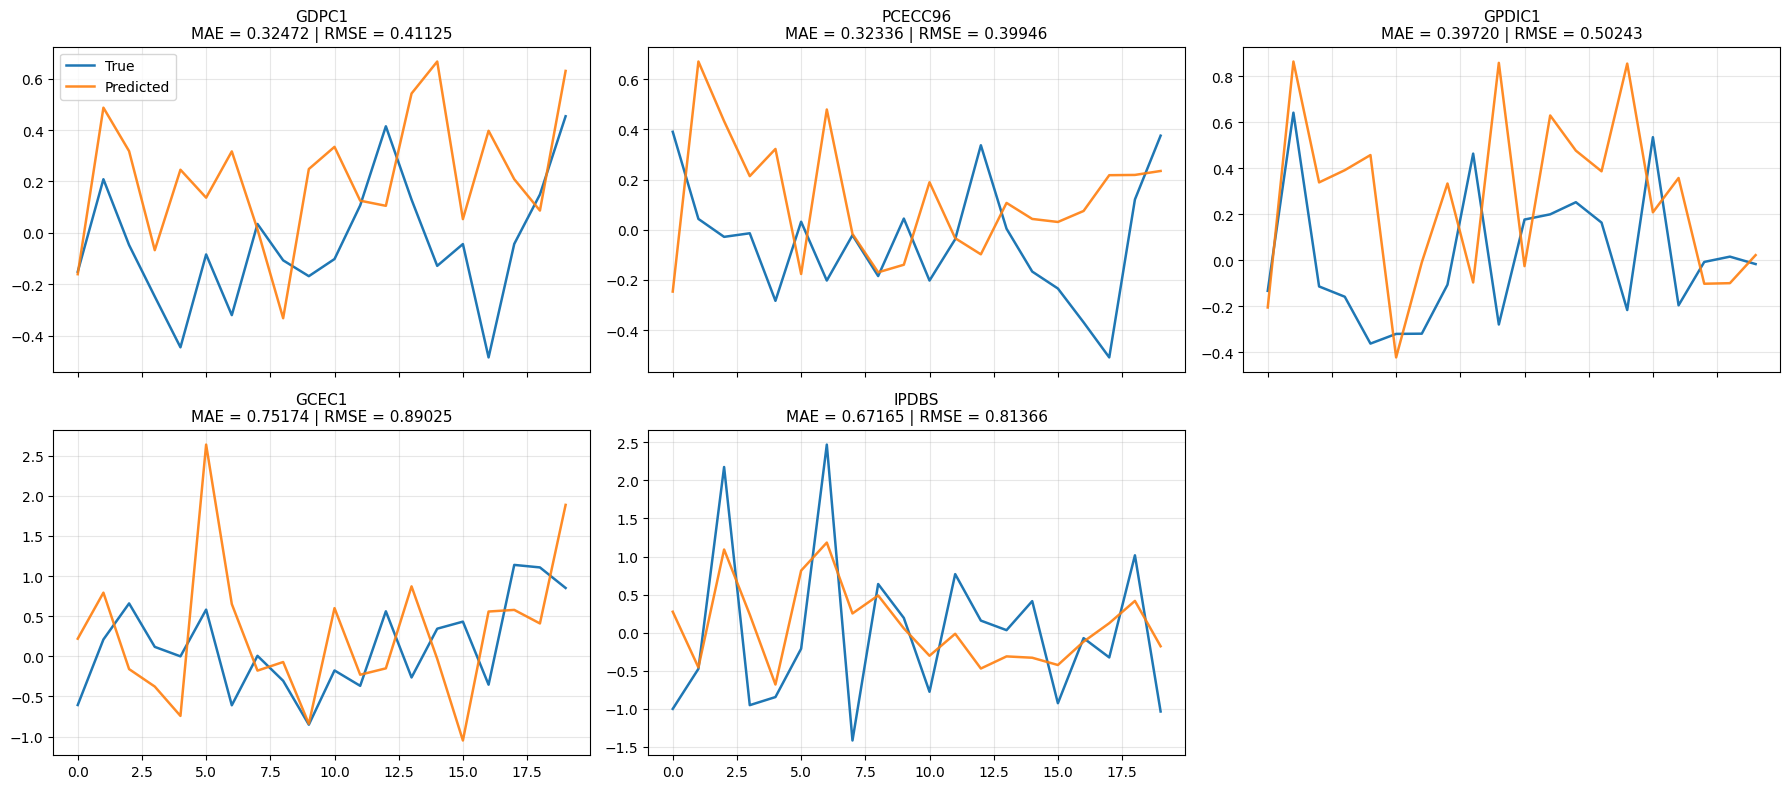


All direct multi-step forecasts and plots saved successfully.

=== Horizon 1 (Direct Forecast t+1) ===
Overall Mean MAE : 0.4937
Overall Mean RMSE: 0.6381


In [2]:
from statsmodels.tsa.vector_ar.var_model import VAR
k = 1
eval_horizon = [0]
eval_horizon_len = len(eval_horizon)
forecasts_multi = np.zeros((eval_horizon_len, Q, T_test))
# forecast_test_VAR = np.zeros((Q, T_test)) 
for i in range(eval_horizon_len):
    eval_horizon_curr = eval_horizon[i]
    target_horizon = int(eval_horizon_curr) + 1
    print(f'\n----- Evaluating Direct Multi-Step Forecasting for Horizon = t+{target_horizon} -----')
    for t in range(T_test):
        # print(f'==== Step {t}')
        X_train_cur = Y_total[Q:,:T_train + T_val + t - target_horizon]
        X_train_cur = create_lagged_data(X_train_cur, k)
        # print('X_train_cur shape:', X_train_cur.shape)
        dim_X_1 = X_train_cur.shape[0]
        # X_train_cur = np.concatenate((np.zeros((dim_X_1, k-1)),X_train_cur), axis=1)
        # print('X_train_cur shape:', X_train_cur.shape)
        Y_train_cur = Y_total[:Q,k+target_horizon-1:T_train + T_val + t]
        # print('Y_train_cur shape:', Y_train_cur.shape)
        # print('X_train_cur shape:', X_train_cur.shape)

        model = VAR(Y_train_cur.T, X_train_cur.T)
        results = model.fit(maxlags=k)

        X_test_cur = Y_total[Q:, T_train + T_val + t - k - target_horizon + 1:T_train + T_val + t - target_horizon + 1].reshape(-1,1)
        Y_test_cur = Y_total[:Q, T_train + T_val + t - k - target_horizon + 1:T_train + T_val + t - target_horizon + 1]
        y_pred = results.forecast(y=Y_test_cur.T, steps=1, exog_future=X_test_cur.T).reshape(-1)
        # print('Forecast at step', t, ':', y_pred.T)
        forecasts_multi[i, :, t] = y_pred.T
        

Y_true = Y_total[:Q, (T_train+T_val):]

for h in range(eval_horizon_len):
    forecast_test = forecasts_multi[h]      # (Q, T_test - eval_horizon + 1)
    forecast_true = Y_true          # (Q, T_test - eval_horizon + 1)

    err_MAE_t, err_MAE = mean_absolute_error(forecast_true, forecast_test)
    err_RMSE_t, err_RMSE = root_mean_squared_error(forecast_true, forecast_test)

    print(f"\n=== Horizon {h+1} (Direct Forecast t+{h+1}) ===")
    print("True matrix:\n", np.round(forecast_true.T, 4))
    print("Forecast matrix:\n", np.round(forecast_test.T, 4))
    print("\nMAE per series :", np.round(err_MAE_t, 4))
    print("RMSE per series:", np.round(err_RMSE_t, 4))
    print("Overall Mean MAE :", f"{err_MAE:.4f}")
    print("Overall Mean RMSE:", f"{err_RMSE:.4f}")

print(f'\n===================== DIRECT: k={k}, eval_horizon={eval_horizon} =====================')

now = datetime.now()
print('Current time:', now.strftime("%Y-%m-%d %H:%M"))

# === Plot forecasts for each horizon ===
for h in range(eval_horizon_len):
    plot_forecasts_multi(
        Y_true, forecasts_multi[h],
        save_path=f'../result/VARX_k{k}_horizon{h+1}.png',
        title_prefix=f'VARX Forecast (Horizon = {h+1})'
    )

print("\nAll direct multi-step forecasts and plots saved successfully.")

for h in range(eval_horizon_len):
    forecast_test = forecasts_multi[h]      # (Q, T_test - eval_horizon + 1)
    forecast_true = Y_true          # (Q, T_test - eval_horizon + 1)

    err_MAE_t, err_MAE = mean_absolute_error(forecast_true, forecast_test)
    err_RMSE_t, err_RMSE = root_mean_squared_error(forecast_true, forecast_test)
    print(f"\n=== Horizon {h+1} (Direct Forecast t+{h+1}) ===")
    print("Overall Mean MAE :", f"{err_MAE:.4f}")
    print("Overall Mean RMSE:", f"{err_RMSE:.4f}")

